# Hawai'i

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import ipywidgets as widgets
from IPython.display import display, IFrame
from fatiando.gravmag import normal_gravity
# Load our custom helper functions from helpers.py
from helpers import plot_field, plot_hawaii_data, minmax

/home/leo/miniconda3/envs/case-studies-gravity/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home/leo/miniconda3/envs/case-studies-gravity/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## Look at in Google Maps

In [2]:
IFrame(width="100%", height="600px", 
       src="https://www.google.com/maps/embed?pb=!1m10!1m8!1m3!1d5916036.911229154!2d-157.7151201!3d20.5932929!3m2!1i1024!2i768!4f13.1!5e1!3m2!1sen!2sbr!4v1413401199263")

## Gravity and Topography

In [3]:
data = xr.open_dataset('data/hawaii-gravity.nc')
data

<xarray.Dataset>
Dimensions:           (latitude: 301, longitude: 301)
Coordinates:
  * latitude          (latitude) float32 13.0 13.05 13.1 13.15 13.2 13.25 ...
  * longitude         (longitude) float32 -165.0 -164.95 -164.9 -164.85 ...
Data variables:
    gravity_earth     (latitude, longitude) float32 ...
    h_over_geoid      (latitude, longitude) float32 ...
    geoid             (latitude, longitude) float32 ...
    topography_grd    (latitude, longitude) float32 ...
    h_over_ellipsoid  (latitude, longitude) float32 ...

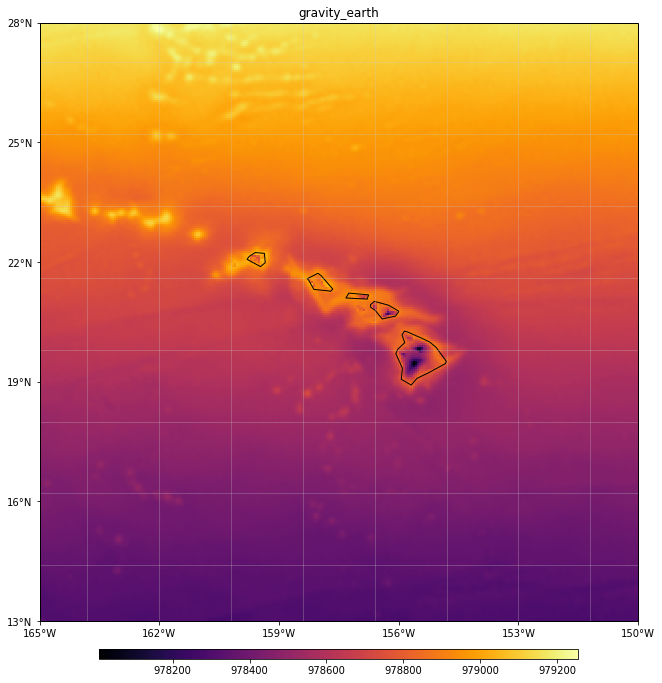

In [4]:
plot_hawaii_data(data, 'gravity_earth', cmap='inferno')

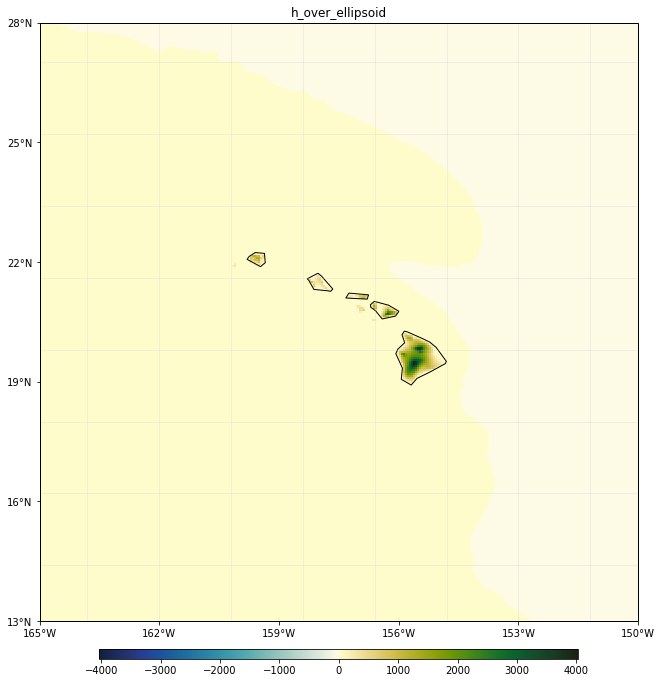

In [5]:
plot_hawaii_data(data, 'h_over_ellipsoid', cmap=cmocean.cm.delta)

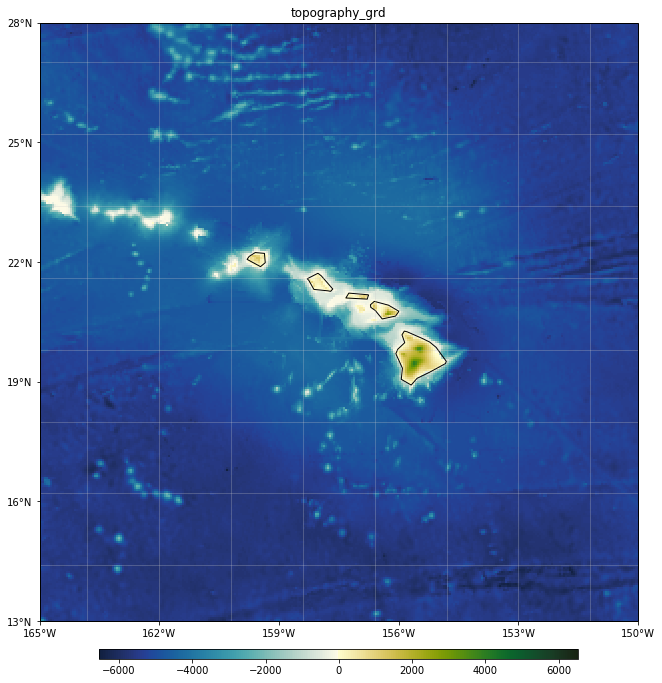

In [6]:
plot_hawaii_data(data, 'topography_grd', cmap=cmocean.cm.delta)

## Normal Gravity

In [7]:
data['normal_gravity'] = normal_gravity.gamma_closed_form(data.latitude, data.h_over_ellipsoid)

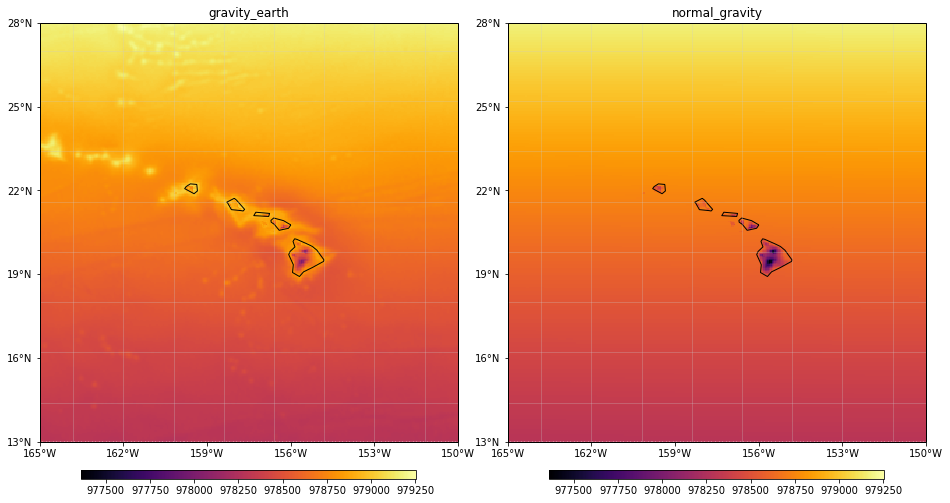

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(13, 8), 
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
fields = ['gravity_earth', 'normal_gravity']
cmaps = ['inferno', 'inferno']
kwargs = minmax(data, fields)
for field, ax, cmap in zip(fields, axes.ravel(), cmaps):
    plot_field(ax, data, field, cmap, cb_pad=0.05, cb_aspect=40, **kwargs)
plt.tight_layout(pad=0)

## Gravity Disturbance

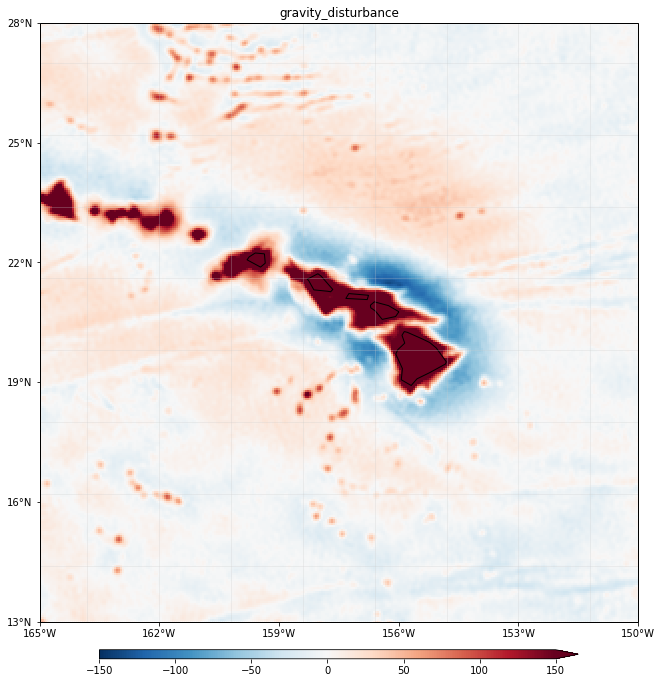

In [9]:
data['gravity_disturbance'] = data.gravity_earth - data.normal_gravity

plot_hawaii_data(data, 'gravity_disturbance', cmap='RdBu_r', vmin=-150, vmax=150)

In [46]:
class ProfileSelector(object):
    def __init__(self, data, fields):
        self.data = data
        self.fields = fields
        self._init = False
        
    def _init_widget(self):
        if not self._init:
            self.topo_base = -10000
            ylim_topo = [self.topo_base, self.data.topography_grd.max()*1.1]
            ylim_data = list(sorted(minmax(self.data, self.fields).values()))

            fig, axes = plt.subplots(2, 1, sharex=True, figsize=(13, 7))
            ax_data, ax_topo = axes

            self.fig = fig
            self.ax_topo = ax_topo
            self.ax_data = ax_data        

            ax_data.set_ylim(ylim_data)
            ax_data.set_ylabel('mGal')
            ax_topo.set_ylim(ylim_topo)
            ax_topo.set_ylabel('Tropography (m)')  

            ax_data.grid(True)

            self.lines = {}
            for field in self.fields:
                self.lines[field], = ax_data.plot([0], [0], '-', label=field)
            ax_data.legend(loc='upper right')

            self.water_fill = None
            self.topo_fill = None
            plt.tight_layout(pad=0)
            
            self._init = True

    def _update_profile(self, value):
        self._init_widget()
        dimension = 'longitude'
        dim_comp = set(self.data.dims).difference({dimension}).pop()

        x = self.data[dim_comp]
        xlim = [x.min(), x.max()]      
        profile = self.data.loc[{dimension: value}]
        
        for field in self.fields:
            self.lines[field].set_data(x, profile[field])
        
        if self.topo_fill is not None:
            self.topo_fill.remove()
        if self.water_fill is not None:
            self.water_fill.remove()
        self.water_fill = self.ax_topo.fill_between(xlim, [0, 0], self.topo_base, color='#2780E3')
        self.topo_fill = self.ax_topo.fill_between(x, profile.topography_grd, self.topo_base, color='#333333')

        self.ax_data.set_xlim(xlim)
        self.ax_topo.set_xlim(xlim)
        self.ax_topo.set_xlabel(dim_comp.capitalize())
        return self.fig
    
    def show(self):
        options = self.data.longitude.values.tolist()[::5]
        mid = options[len(options)//2]
        slider = widgets.SelectionSlider(options=options, value=options[0])

        widget = widgets.interact(self._update_profile, value=slider)
        slider.value = mid
        return widget
        

    

In [48]:
ProfileSelector(data, ['geoid']).show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KFNlbGVjdGlvblNsaWRlcihkZXNjcmlwdGlvbj11J3ZhbHVlJywgb3B0aW9ucz0oLTE2NS4wLCAtMTY0Ljc1LCAtMTY0LjUsIC0xNjQuMjUsIC0xNjQuMCzigKY=


<function ipywidgets.widgets.interaction.<lambda>>

## Bouguer correction

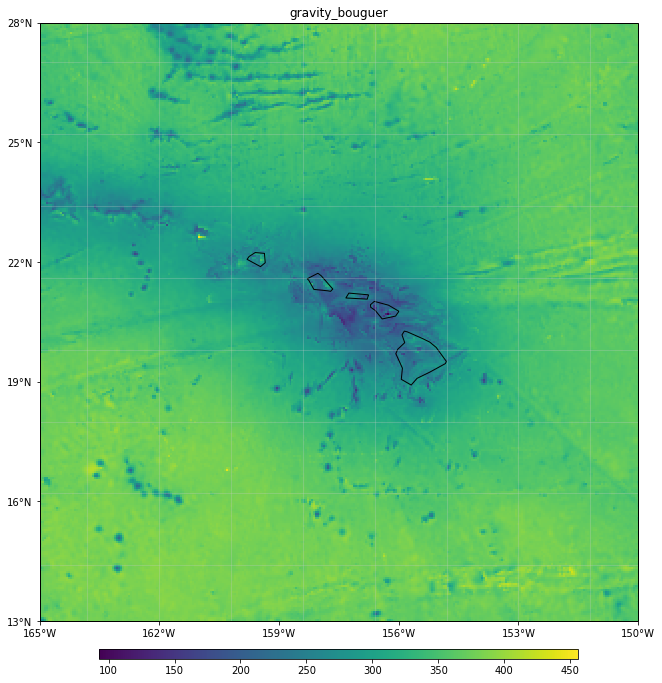

In [49]:
data['gravity_bouguer'] = data.gravity_disturbance - normal_gravity.bouguer_plate(data.topography_grd)

plot_hawaii_data(data, 'gravity_bouguer')